# Matching tool 

geinspireerd door : https://towardsdatascience.com/dating-algorithms-using-machine-learning-and-ai-814b68ecd75e 
data set verkregen door : https://generatedata.com/generator

## Importeren 

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# pip install seaborn
# pip install sklearn
#pip install tensorflo 

In [3]:
df = pd.read_json("data-for_model.json")
df

,k1,k2,k3,k4,k5,S1,S2,D4
0,47,95,0,91,90,17,1,36
1,56,91,0,44,89,7,0,36
2,41,41,1,65,1,40,1,36
3,57,89,1,92,84,56,1,32
4,45,87,1,21,6,94,1,36
...,...,...,...,...,...,...,...,...
295,30,37,1,89,73,83,1,24
296,62,11,1,47,52,75,0,36
297,74,35,0,19,48,3,0,40
298,63,13,0,79,61,39,1,40


## Voorbewerken van de data 

In [4]:
from sklearn.preprocessing import StandardScaler

# scaling the data 
scaler = StandardScaler().fit(df)
array_scaled = scaler.transform(df)

In [5]:
df_scaled = pd.DataFrame(array_scaled, columns = ['k1', 'k2', 'k3', 'k4', 'k5', 's1', 's2', 'd4'])
df_scaled

,k1,k2,k3,k4,k5,s1,s2,d4
0,-0.072216,1.620024,-1.033908,1.533957,1.464342,-1.181239,1.105542,0.583768
1,0.244831,1.478093,-1.033908,-0.183023,1.429811,-1.532102,-0.904534,0.583768
2,-0.283581,-0.296044,0.967204,0.584138,-1.608912,-0.374254,1.105542,0.583768
3,0.280058,1.407127,0.967204,1.570489,1.257156,0.187127,1.105542,-0.238440
4,-0.142671,1.336162,0.967204,-1.023247,-1.436257,1.520406,1.105542,0.583768
...,...,...,...,...,...,...,...,...
295,-0.671082,-0.437975,0.967204,1.460894,0.877316,1.134457,1.105542,-1.882856
296,0.456195,-1.360527,0.967204,-0.073428,0.152166,0.853767,-0.904534,0.583768
297,0.878924,-0.508941,-1.033908,-1.096310,0.014043,-1.672447,-0.904534,1.405976
298,0.491422,-1.289561,-1.033908,1.095579,0.462945,-0.409340,1.105542,1.405976


In [6]:
# bewijs dat het genormaliseerd : 
df_scaled.mean()

# afgerond is dit 0 --> goed genormaliseerd 

k1    1.065814e-16
k2    5.921189e-18
k3   -1.450691e-16
k4    7.105427e-17
k5   -2.368476e-17
s1    8.289665e-17
s2   -1.184238e-17
d4    7.016610e-16
dtype: float64

## Cluster methode bepalen

In [7]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# kiezen van het aantal clusters 

cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scoresA = []
db_scoresA = []

s_scoresB = []
db_scoresB = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_scaled)
    
    cluster_assignmentsA = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(df_scaled)
    
    cluster_assignmentsB = k_means.predict(df_scaled)
    
    # Appending the scores to the empty lists    
    s_scoresA.append(silhouette_score(df_scaled, cluster_assignmentsA))
    db_scoresA.append(davies_bouldin_score(df_scaled, cluster_assignmentsA))
    
    s_scoresB.append(silhouette_score(df_scaled, cluster_assignmentsB))
    db_scoresB.append(davies_bouldin_score(df_scaled, cluster_assignmentsB))

In [8]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
        
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('Het aantal clusters')
    plt.ylabel('Score')
    plt.show()
    


Grafiek 1  - "The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect. "

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam#:~:text=The%20silhouette%20score%20of%201,value%20of%20the%20K%20(no.


Grafiek 2 - "Davies-Bouldin index is a validation metric that is often used in order to evaluate the optimal number of clusters to use. It is defined as a ratio between the cluster scatter and the cluster's separation and a lower value will mean that the clustering is better " 

https://stackoverflow.com/questions/59279056/davies-bouldin-index-higher-or-lower-score-better#:~:text=Davies%2DBouldin%20index%20is%20a,that%20the%20clustering%20is%20better.


Max Value:
Cluster #     Cluster Score
19       0.129011

Min Value:
Cluster #    Cluster Score
5       0.077047


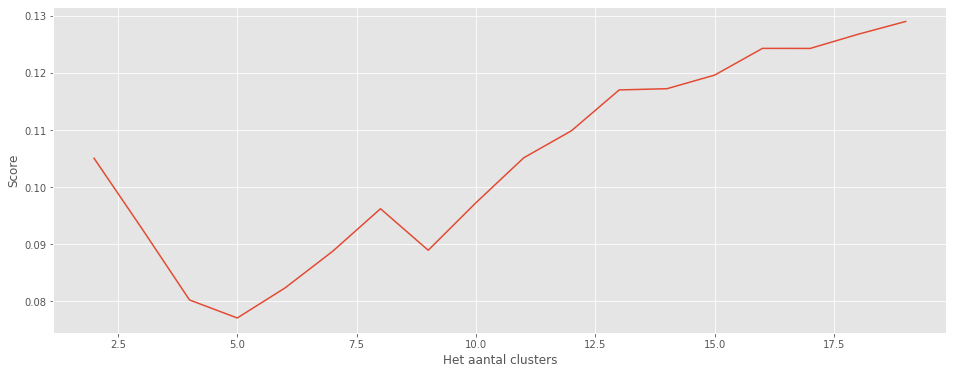

Max Value:
Cluster #    Cluster Score
2       2.790762

Min Value:
Cluster #     Cluster Score
19        1.61575


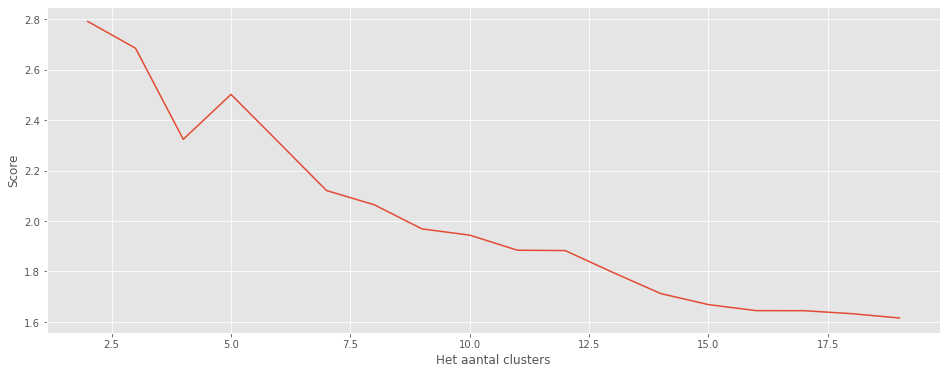

In [9]:
# Running the function on the list of scores
plot_evaluation(s_scoresA)
plot_evaluation(db_scoresA)

Dus vanuit deze twee grafieken is 16 het optimale aantal clusters. En gebruiken kmeans 

### AgglomerativeClustering

grafiek 1 de max is bij 19 clusters met een waarde van 0.129011

grafiek 2 de min is bij 19 clusters met een waarde van 1.61575

Max Value:
Cluster #     Cluster Score
18       0.141492

Min Value:
Cluster #    Cluster Score
7        0.11702


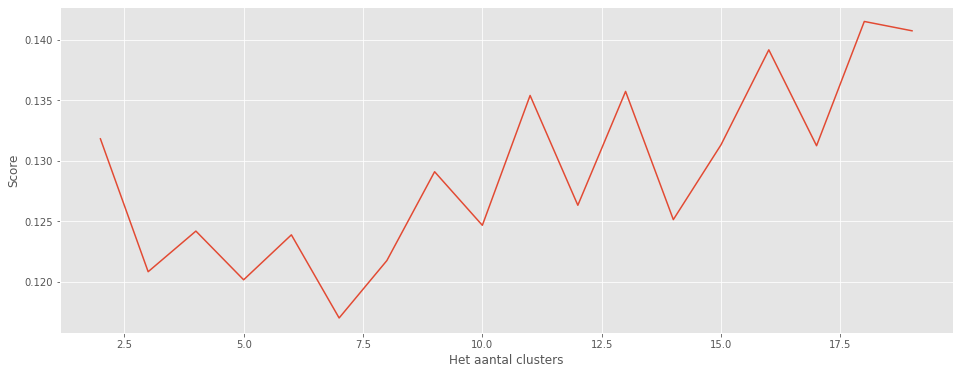

Max Value:
Cluster #    Cluster Score
2       2.521468

Min Value:
Cluster #     Cluster Score
18        1.56355


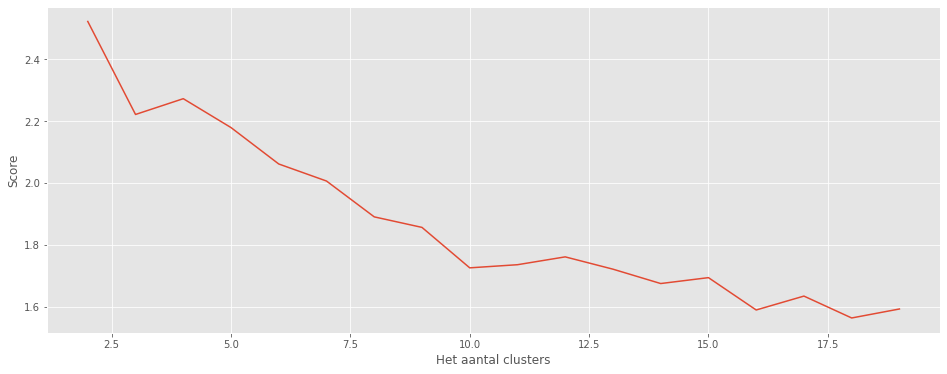

In [10]:
plot_evaluation(s_scoresB)
plot_evaluation(db_scoresB)

### Kmeans 
grafiek 1 de max is bij 17 clusters met een waarde van 0.140338

grafiek 2 de min is bij 19 clusters met een waarde van 1.595732

### Conclusie 
De waarden zijn nagenoeg gelijk voor beide clustering methodes. Maar AgglomerativeClustering heeft een kleine voor sprong. En heeft bij beide evaluatie methodes de piek/dal bij 19 zitten. 

## Clusteren 

In [11]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=19)

# Fitting
hac.fit(df_scaled)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
df_scaled['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df_scaled

,k1,k2,k3,k4,k5,s1,s2,d4,Cluster #
0,-0.072216,1.620024,-1.033908,1.533957,1.464342,-1.181239,1.105542,0.583768,12
1,0.244831,1.478093,-1.033908,-0.183023,1.429811,-1.532102,-0.904534,0.583768,9
2,-0.283581,-0.296044,0.967204,0.584138,-1.608912,-0.374254,1.105542,0.583768,16
3,0.280058,1.407127,0.967204,1.570489,1.257156,0.187127,1.105542,-0.238440,14
4,-0.142671,1.336162,0.967204,-1.023247,-1.436257,1.520406,1.105542,0.583768,18
...,...,...,...,...,...,...,...,...,...
295,-0.671082,-0.437975,0.967204,1.460894,0.877316,1.134457,1.105542,-1.882856,14
296,0.456195,-1.360527,0.967204,-0.073428,0.152166,0.853767,-0.904534,0.583768,3
297,0.878924,-0.508941,-1.033908,-1.096310,0.014043,-1.672447,-0.904534,1.405976,9
298,0.491422,-1.289561,-1.033908,1.095579,0.462945,-0.409340,1.105542,1.405976,1


C:\Users\Merel\AppData\Local\Temp/ipykernel_10576/2011793269.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter)


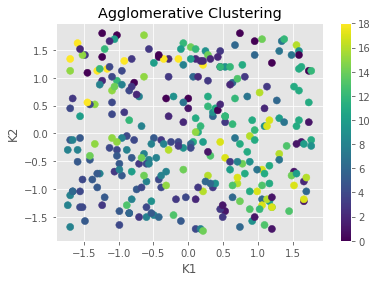

In [12]:
data = df_scaled
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data['k1'],[data['k2']], c=data["Cluster #"],s=50)
ax.set_title("Agglomerative Clustering")
ax.set_xlabel("K1"); ax.set_ylabel("K2")
plt.colorbar(scatter)
plt.show()

In [13]:
df["# Cluster"] = data["Cluster #"]
df_grouped = df.groupby(by = ["# Cluster"]).mean()
df_grouped

,k1,k2,k3,k4,k5,S1,S2,D4
# Cluster,,,,,,,,
0,48.533333,84.333333,0.000000,59.533333,30.800000,79.133333,0.466667,33.066667
1,79.083333,28.250000,0.000000,84.666667,58.666667,57.500000,0.250000,32.333333
2,49.000000,71.444444,0.722222,76.388889,49.166667,23.444444,0.000000,27.555556
3,43.080000,51.520000,1.000000,24.280000,61.960000,66.720000,0.000000,35.200000
4,24.642857,38.857143,0.000000,45.607143,35.571429,54.357143,1.000000,34.857143
5,17.368421,26.947368,0.842105,54.578947,35.157895,43.105263,0.000000,29.684211
6,59.187500,40.250000,1.000000,16.000000,62.750000,59.250000,1.000000,34.750000
7,78.111111,64.222222,0.666667,35.333333,34.777778,70.777778,1.000000,24.000000
8,26.241379,36.068966,0.000000,54.068966,41.344828,42.172414,0.000000,35.586207


hierboven staan alle gemiddelde van de verschillende clusters. Op deze clusters gaat er dus een model gemaakt worden. 

## TF -Model 

In [14]:
np.set_printoptions(precision=3, suppress=True)

In [15]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
print(tf.__version__)

2.9.1


In [17]:
df["# Cluster"] = data["Cluster #"]
dataset = df.copy()

In [19]:
dataset.isna().sum()

k1           0
k2           0
k3           0
k4           0
k5           0
S1           0
S2           0
D4           0
# Cluster    0
dtype: int64

Geen NaN of gemiste data. --> data klaar voor training

In [20]:
# Data splitsen in training en test sets 
train_dataset = dataset.sample(frac=0.8 , random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

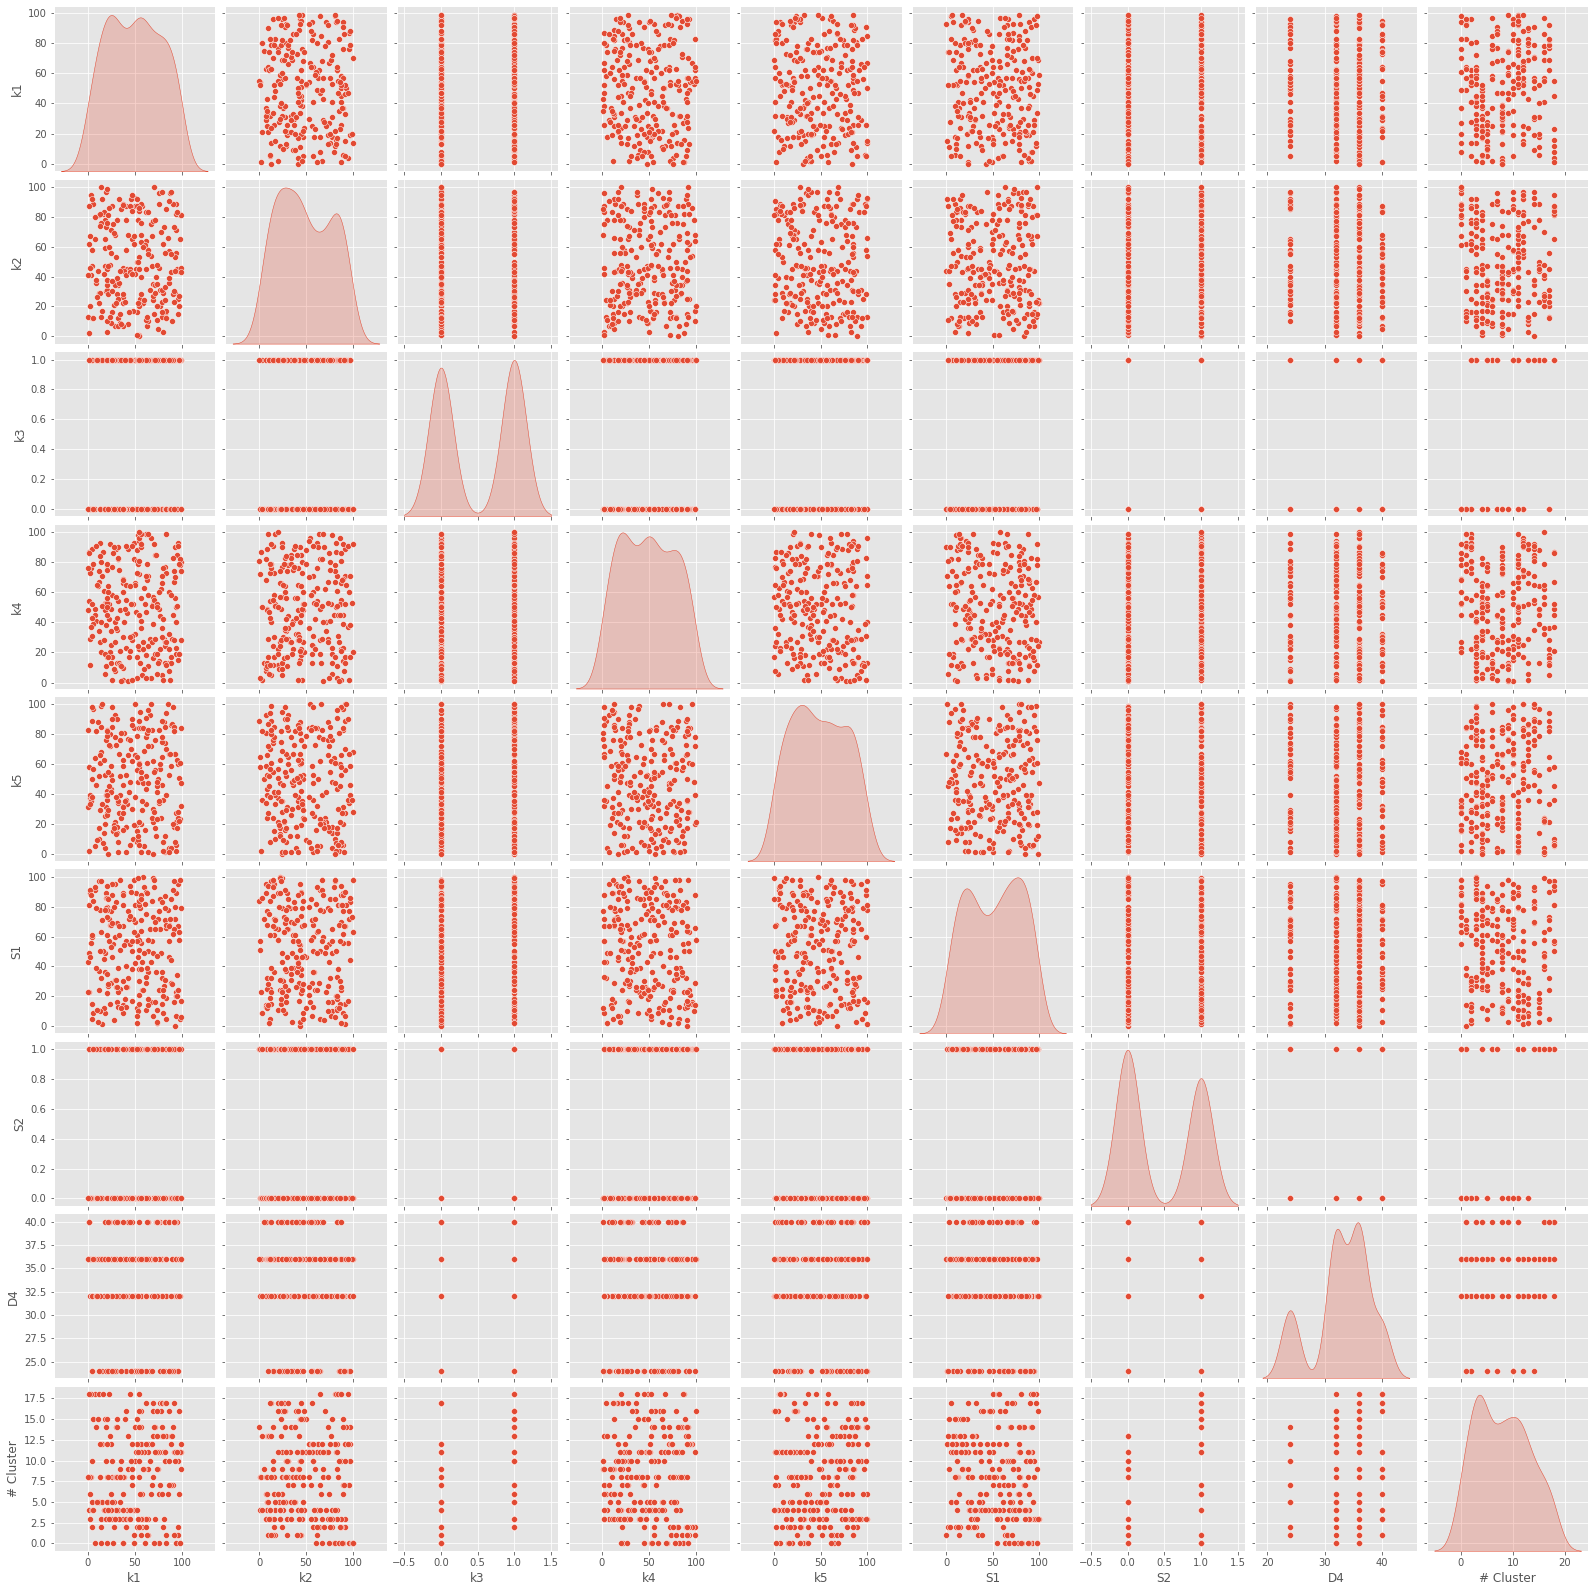

In [21]:
sns.pairplot(train_dataset, diag_kind='kde')

De grafiek hierboven laat zien dat er geen duidelijke functies zijn tussen het resultaat (het cluster nummer) en de andere colums. 

In [22]:
# Nu verdelen we de dataset in train en test 
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('# Cluster')
test_labels = test_features.pop('# Cluster')

Om de verschillende colommen te normaliseren gebruiken we de keras normalisatie laag 

In [26]:
from tensorflow.keras.layers import Normalization 

normalizer = Normalization(axis = -1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[49.546 48.763  0.513 48.95  47.933 51.558  0.45  33.133]]


In [27]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[25  9  0 49 43 77  1 32]]

Normalized: [[-0.87 -1.41 -1.03  0.   -0.17  0.88  1.11 -0.23]]


Hierboven zie je het verschil tussen genormaliseerd en rauwe data. Genormaliseerde data zorgt ervoor dat in het neurale netwerk de gewichten die aan elke berekening/handeling worden gehangen, sneller berekent kunnen worden. 

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),layers.Dropout(.2, input_shape=(2,)), 
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
model1 = build_and_compile_model(normalizer)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_____________________________________________________

In [51]:
%%time
history = model1.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.19 s


In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Cluster]')
  plt.legend()
  plt.grid(True)

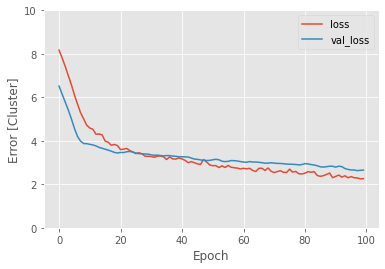

In [37]:
plot_loss(history)

In [49]:
gem_afwijking = model1.evaluate(test_features, test_labels, verbose=0)

In [50]:
gem_afwijking

3.0112452507019043

x is de gemiddelde absolute afwijking dit berekent het gemiddelde verschil tussen de berekende en de echte waarden. Hoe kleiner deze is, hoe beter het model getraind is. 

2/2 [==============================] - 0s 4ms/step


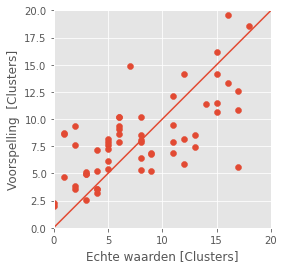

In [48]:
test_predictions = model1.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('Echte waarden [Clusters]')
plt.ylabel('Voorspelling  [Clusters]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Hoe dichter de punten bij de rechte lijn liggen. Hoe beter het model voorspelt. 